In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
from IPython.display import HTML, display
from IPython.core import display as ICD
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

import math
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import itertools
import warnings
warnings.filterwarnings('ignore')

## Preprocess data

In [2]:
PATH = 'rainfall_data_1901_to_2002.xlsx'

In [3]:
data = pd.read_excel(PATH)

In [4]:
data = data.drop(columns='vlookup')
data = data[data['Year'].notnull()]
data['Year'] = data.Year.astype('int')
data.index = range(len(data))
data.head()

,State,District,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,Andhra Pradesh,Adilabad,1901,6.725,10.488,23.288,35.560,23.119,115.546,294.119,276.865,181.615,47.310,1.339,0.000
1,Andhra Pradesh,Adilabad,1902,0.420,0.000,0.388,6.070,3.331,45.960,233.973,167.971,198.177,26.447,35.083,11.222
2,Andhra Pradesh,Adilabad,1903,6.643,1.956,0.173,4.551,33.348,132.078,436.611,334.544,226.037,138.818,14.095,8.823
3,Andhra Pradesh,Adilabad,1904,0.054,0.121,11.446,0.017,16.900,131.048,160.694,81.865,251.577,110.391,0.146,0.130
4,Andhra Pradesh,Adilabad,1905,0.589,2.293,8.252,35.020,17.569,79.937,96.331,313.522,361.697,4.950,0.146,0.000


In [5]:
m_data = data[data['State'] == 'Maharashtra']
m_data = m_data.drop(columns='State')
m_data.head()

,District,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
26826,Ahmadnagar,1901,2.510,11.489,11.325,33.931,30.401,262.971,162.397,120.152,58.708,62.633,0.596,0.000
26827,Ahmadnagar,1902,0.603,0.000,0.003,1.340,6.338,90.293,223.483,101.852,297.212,61.453,41.992,26.715
26828,Ahmadnagar,1903,0.227,0.000,0.000,2.602,69.076,182.652,500.983,156.236,164.433,88.419,2.022,3.999
26829,Ahmadnagar,1904,0.937,1.126,1.051,2.378,4.365,120.658,117.058,38.470,225.726,72.389,0.271,0.000
26830,Ahmadnagar,1905,0.000,0.622,0.000,0.452,4.115,114.385,197.696,116.061,54.338,66.508,6.581,0.000


In [18]:
districts = m_data.District.unique()
years = list(range(1901, 2003))
months = data.columns[3:]
year_month = [str(year) + '_' + month for year in years for month in months]
dates = pd.date_range(start='1901-01', freq='MS', periods=len(years)*12)

In [20]:
maharashtra_data = pd.DataFrame({'Year_Month': year_month})
maharashtra_data['Date'] = dates
maharashtra_data[['Year', 'Month']] = maharashtra_data['Year_Month'].str.split('_', n=1, expand=True)
maharashtra_data = maharashtra_data.drop(columns=['Year_Month'])

for district in districts:
    df = m_data[m_data.District == district].drop(columns=['District', 'Year'])
    df = df.as_matrix().reshape((len(years) * len(months), 1))[:,0]
    maharashtra_data[district] = df

maharashtra_data.head()

,Date,Year,Month,Ahmadnagar,Akola,Amravati,Aurangabad,Bhandara,Bid,Buldana,...,Nashik,Osmanabad,Parbhani,Pune,Sangli,Satara,Solapur,Wardha,Washim,Yavatmal
0,1901-01-01,1901,Jan,2.510,34.202,35.651,10.922,23.397,16.647,31.455,...,5.063,15.500,33.207,0.922,0.138,0.197,4.496,45.050,32.485,22.031
1,1901-02-01,1901,Feb,11.489,1.099,6.822,4.362,63.844,1.916,0.823,...,1.609,2.784,4.997,7.195,0.537,0.525,3.667,28.220,3.607,16.198
2,1901-03-01,1901,Mar,11.325,30.002,36.103,25.161,33.563,27.287,28.448,...,11.196,11.333,31.625,5.105,13.090,9.566,10.330,26.398,26.557,29.318
3,1901-04-01,1901,Apr,33.931,10.248,10.636,12.714,61.560,33.211,13.902,...,7.838,34.814,41.941,35.949,50.077,30.110,59.854,29.228,18.127,30.521
4,1901-05-01,1901,May,30.401,2.891,4.173,34.244,13.665,59.027,9.397,...,7.475,52.792,31.794,36.650,78.994,65.226,50.892,8.619,6.700,13.193


## Correlation matrix - Districts

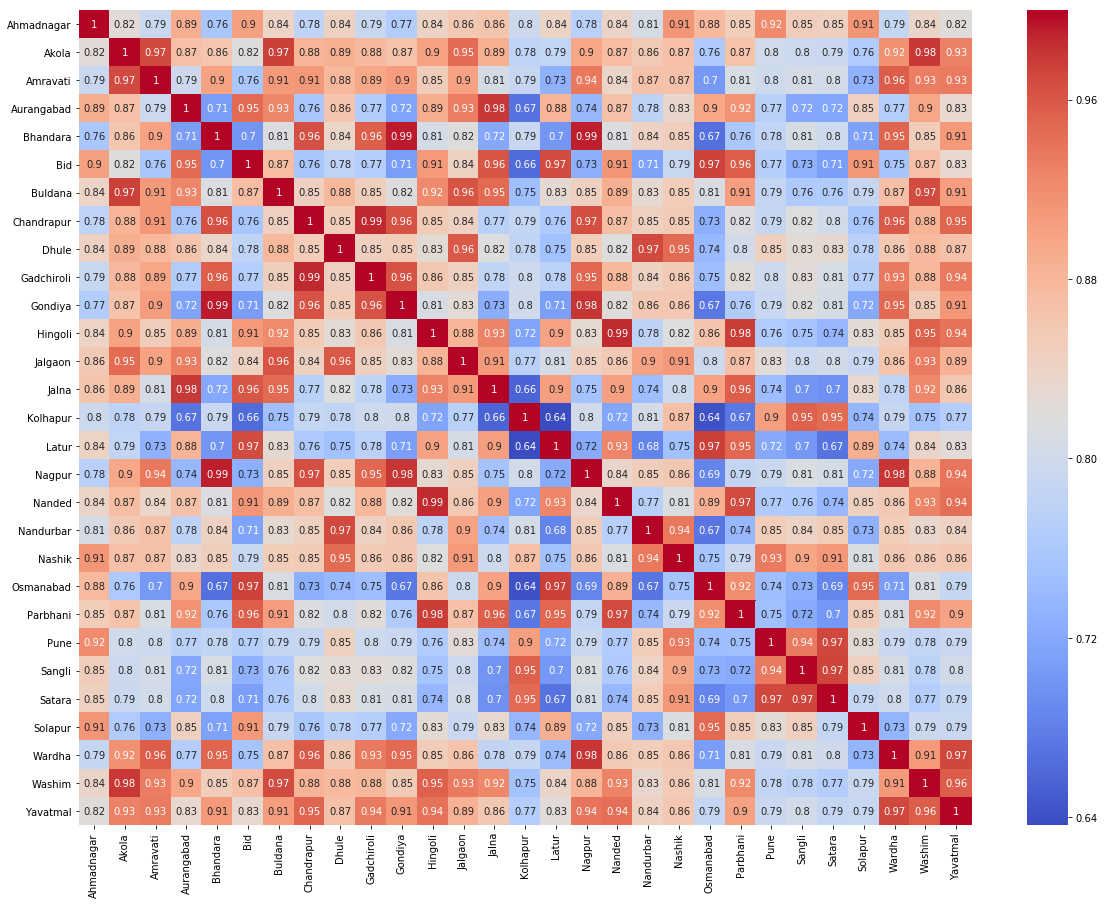

In [215]:
corr_matrix = maharashtra_data.drop(columns=['Year', 'Month']).corr().abs()
plt.figure(figsize=(20,15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

## Highly correlated districts

In [216]:
def return_highly_correlated(corr_matrix, corr_coef):
    district_corr = corr_matrix.abs().unstack().sort_values().drop_duplicates()
    tuples = district_corr[(district_corr > corr_coef) & (district_corr != 1.0)]
    levels = tuples.index.levels[0]
    labels = tuples.index.labels

    high_corr_districts = []
    for i in range(len(labels[0])):
        high_corr_districts.append([levels[labels[0][i]], levels[labels[1][i]], tuples[i]])
    high_corr_districts = np.array(high_corr_districts)
    df = pd.DataFrame({'District1': high_corr_districts[:, 0], 
                      'District2': high_corr_districts[:, 1],
                      'Correlation_coefficient': high_corr_districts[:, 2]},
                     columns = ['District1', 'District2', 'Correlation_coefficient'])
    return df

In [217]:
high_corr_districts = return_highly_correlated(corr_matrix, 0.98)
high_corr_districts

,District1,District2,Correlation_coefficient
0,Nagpur,Gondiya,0.9805330709528167
1,Nagpur,Wardha,0.9811563634226902
2,Nanded,Hingoli,0.9858166679818119
3,Chandrapur,Gadchiroli,0.9885737788804028
4,Nagpur,Bhandara,0.9907760645844106
5,Bhandara,Gondiya,0.9922307205938624


## Precipitation data of the district "Pune"

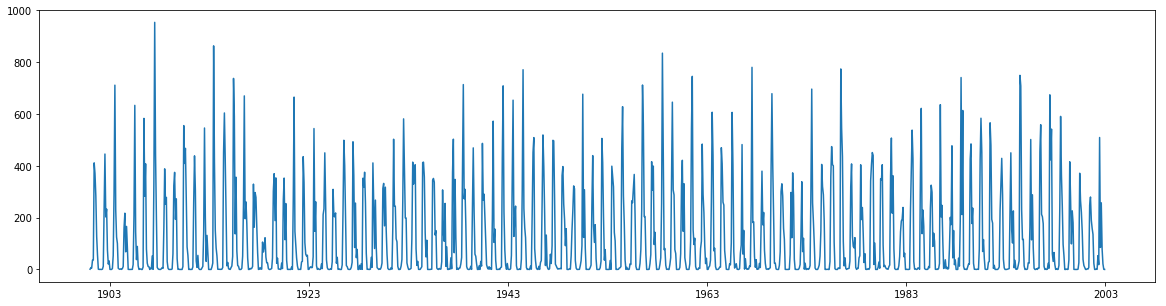

In [30]:
plt.figure(figsize=(20,5))
plt.plot(maharashtra_data.Date, maharashtra_data.Pune)

## Plot the districts with heavy rainfall over all years(>700|800mm)

In [218]:
high_rainfall = {}
for district in districts:
    count = len(maharashtra_data[maharashtra_data[district]>=800])
    if count != 0:
        high_rainfall[district] = count
high_rainfall

{'Kolhapur': 49,
 'Nandurbar': 10,
 'Nashik': 1,
 'Pune': 3,
 'Sangli': 1,
 'Satara': 25}

## Boxplot - District wise precipitation across all years

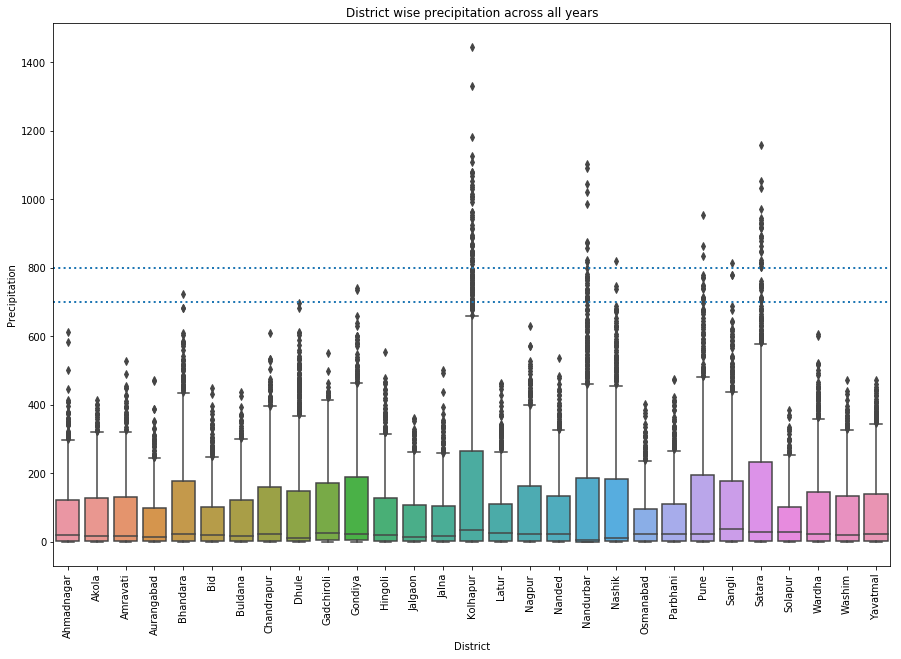

In [117]:
matrix = maharashtra_data.drop(columns=['Date', 'Year', 'Month'])

plt.figure(figsize=(15,10))
g = sns.boxplot(x="variable", y="value", data=pd.melt(matrix))
labels = g.get_xticklabels()
g.set_xticklabels(labels, rotation=90)
g.set_xlabel('District')
g.set_ylabel('Precipitation')
g.set_title('District wise precipitation across all years')
plt.axhline(y=700, linewidth=2, linestyle='dotted')
plt.axhline(y=800, linewidth=2, linestyle='dotted')

- In district 'Kolhapur', the precipitation is above 800mm for many times. It says that the rainfall was heavy in Kolhapur district.

## Yearly average precipitation data across all districts in Maharashtra

In [357]:
m_data_copy = maharashtra_data.copy()
m_data_copy = m_data_copy.drop(columns=['Date', 'Year', 'Month'])
m_data_copy = m_data_copy.groupby(np.arange(len(df))//12).mean()
columns = m_data_copy.columns
columns = columns.insert(0, 'Year')
m_data_copy['Year'] = maharashtra_data.Year.unique()
m_data_copy = m_data_copy.reindex(columns=columns)
m_data_copy.set_index('Year', inplace=True)

In [358]:
m_data_copy.head()

,Ahmadnagar,Akola,Amravati,Aurangabad,Bhandara,Bid,Buldana,Chandrapur,Dhule,Gadchiroli,...,Nashik,Osmanabad,Parbhani,Pune,Sangli,Satara,Solapur,Wardha,Washim,Yavatmal
Year,,,,,,,,,,,,,,,,,,,,,
1901,63.092750,77.823333,73.880833,62.966417,89.942500,68.990750,82.473833,92.038500,65.832667,82.867167,...,82.748167,56.653750,72.188500,111.361167,93.724583,131.658083,55.418750,85.357167,76.065333,82.455833
1902,70.940333,59.357500,61.660417,57.995167,67.120917,58.366167,56.106333,63.641167,93.626833,64.669333,...,108.657333,54.276250,59.543417,105.194917,93.180500,127.642583,52.421833,67.705750,62.795333,64.140083
1903,97.554083,78.115750,78.562250,65.851333,131.699667,74.999000,75.238000,112.471250,121.145583,113.153167,...,125.389917,87.275417,86.754917,127.237417,116.895250,130.759500,85.031583,97.724917,89.132250,101.637750
1904,48.702417,58.301917,48.570083,60.179417,77.639417,57.015417,64.512667,66.476000,65.572833,71.484583,...,77.788500,50.810000,60.305917,59.527833,69.020917,80.311583,43.898083,59.393333,65.820500,61.974667
1905,46.729833,56.520417,66.528167,37.807083,115.219833,36.920667,54.126833,93.275583,66.059417,95.537417,...,74.322667,38.655583,45.336000,95.595917,69.095750,111.762833,37.047167,83.216500,54.317333,69.244500


## Monthly rainfall for each year in Maharashtra

In [388]:
m_data_copy = m_data.copy()
m_data_copy['Jan-Feb'] = m_data_copy['Jan'] + m_data_copy['Feb']
m_data_copy['Mar-May'] = m_data_copy['Mar'] + m_data_copy['Apr'] + m_data_copy['May']
m_data_copy['Jun-Sep'] = m_data_copy['Jun'] + m_data_copy['Jul'] + m_data_copy['Aug'] + m_data_copy['Sep']
m_data_copy['Oct-Dec'] = m_data_copy['Oct'] + m_data_copy['Nov'] + m_data_copy['Dec']
m_data_copy['Annual'] = m_data_copy['Jan-Feb'] + m_data_copy['Mar-May'] + m_data_copy['Jun-Sep'] + m_data_copy['Oct-Dec']
m_data_copy.head()

,District,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Jan-Feb,Mar-May,Jun-Sep,Oct-Dec,Annual
26826,Ahmadnagar,1901,2.510,11.489,11.325,33.931,30.401,262.971,162.397,120.152,58.708,62.633,0.596,0.000,13.999,75.657,604.228,63.229,757.113
26827,Ahmadnagar,1902,0.603,0.000,0.003,1.340,6.338,90.293,223.483,101.852,297.212,61.453,41.992,26.715,0.603,7.681,712.840,130.160,851.284
26828,Ahmadnagar,1903,0.227,0.000,0.000,2.602,69.076,182.652,500.983,156.236,164.433,88.419,2.022,3.999,0.227,71.678,1004.304,94.440,1170.649
26829,Ahmadnagar,1904,0.937,1.126,1.051,2.378,4.365,120.658,117.058,38.470,225.726,72.389,0.271,0.000,2.063,7.794,501.912,72.660,584.429
26830,Ahmadnagar,1905,0.000,0.622,0.000,0.452,4.115,114.385,197.696,116.061,54.338,66.508,6.581,0.000,0.622,4.567,482.480,73.089,560.758


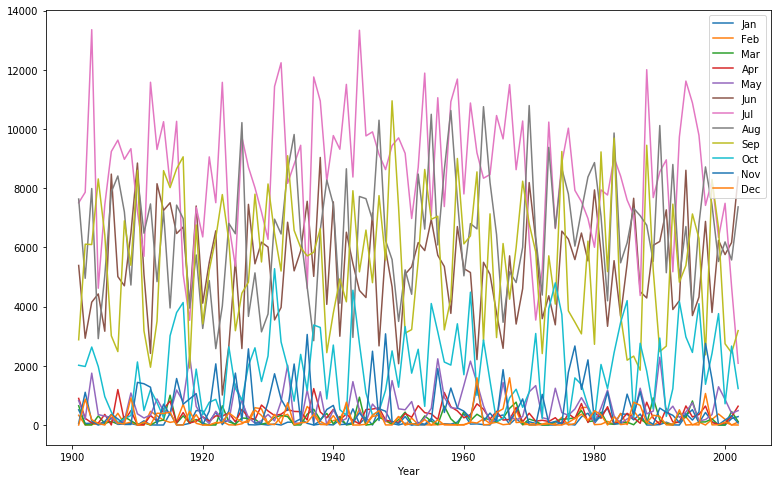

In [392]:
months = list(m_data.columns[1:])
m_data_copy[months].groupby("Year").sum().plot(figsize=(13,8))

## Seasonal rainfall for each year in Maharashtra

In [393]:
seasonal_data = m_data_copy[['Year','Jan-Feb', 'Mar-May', 'Jun-Sep', 'Oct-Dec']].groupby("Year").sum()

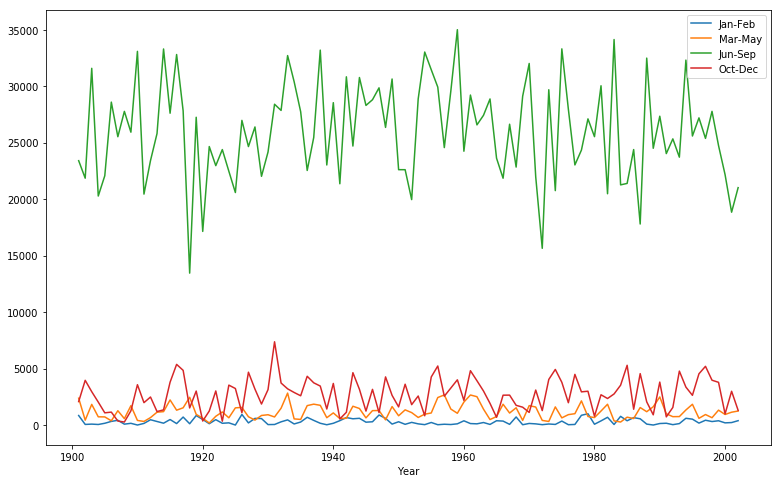

In [394]:
seasonal_data.plot(figsize=(13,8))

## District wise Seasonal rainfall across all years

In [395]:
seasonal_district_data = m_data_copy[['District','Jan-Feb', 'Mar-May', 'Jun-Sep', 'Oct-Dec']].groupby("District").sum()
seasonal_district_data.head()

,Jan-Feb,Mar-May,Jun-Sep,Oct-Dec
District,,,,
Ahmadnagar,249.735,4052.170,72472.375,9793.123
Akola,1396.348,2430.082,71598.467,9373.896
Amravati,1570.125,2631.008,76188.207,8760.707
Aurangabad,374.951,3030.083,56120.789,9403.228
Bhandara,3109.308,4954.334,111808.461,7086.156


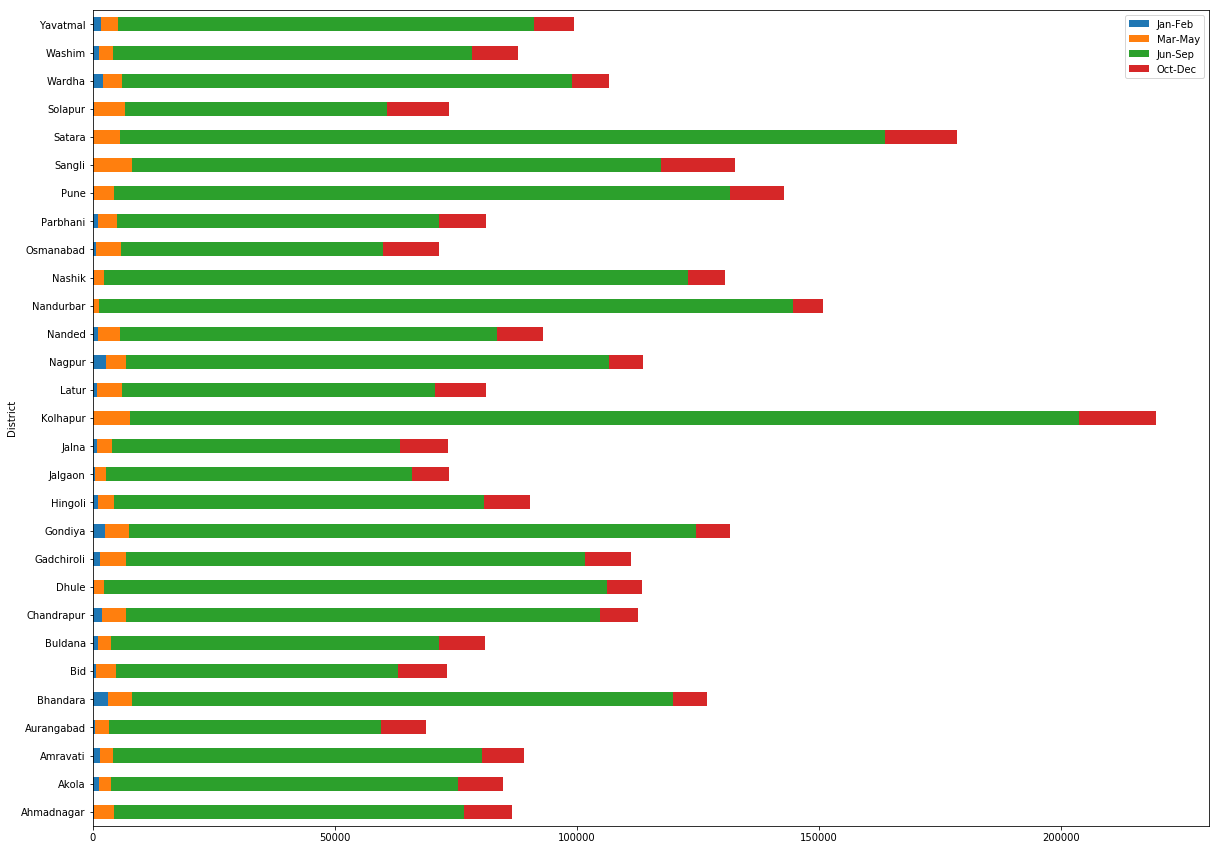

In [396]:
seasonal_district_data.plot.barh(stacked=True,figsize=(20,15));

## District wise Monthly mean precipitation across all years

In [397]:
columns = list(m_data.columns[2:])
columns.insert(0, m_data.columns[0])
monthly_mean_data = m_data_copy[columns].groupby("District").mean()
monthly_mean_data.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
District,,,,,,,,,,,,
Ahmadnagar,0.764765,1.683618,2.516147,10.872980,26.338029,165.464843,233.050088,146.425843,165.572706,66.866951,23.717127,5.426931
Akola,8.296598,5.393088,8.215549,5.283069,10.325716,146.805363,216.788843,183.560373,154.791176,58.458794,23.729500,9.712647
Amravati,9.114353,6.279029,11.095029,5.637853,9.061314,145.434049,250.601422,205.358167,145.549569,53.563343,22.682284,9.643657
Aurangabad,2.308088,1.367902,3.273343,6.156657,20.276696,111.857392,149.430108,105.088363,183.827951,53.443627,30.078951,8.665931
Bhandara,10.836088,19.647324,15.275010,17.592314,15.704578,184.951412,373.926020,338.800657,198.483294,50.267510,9.901167,9.303441


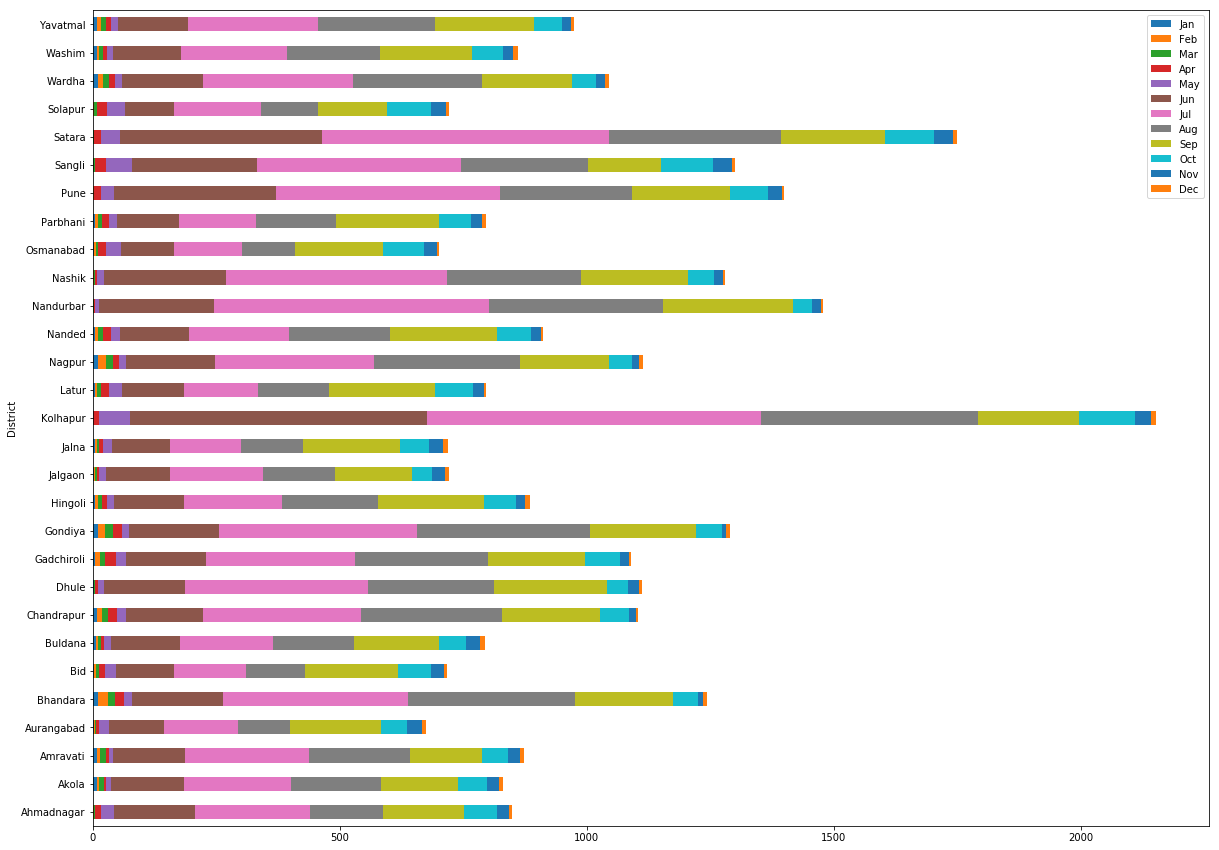

In [398]:
monthly_mean_data.plot.barh(stacked=True,figsize=(20,15));

## Annual rainfall in Maharshtra

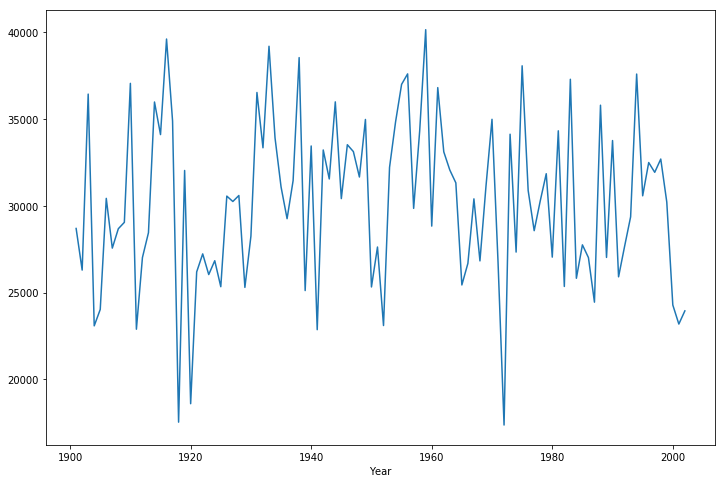

In [400]:
Annual_rainfall = m_data_copy.groupby('Year').sum()['Annual']
Annual_rainfall.plot(figsize=(12,8))